In [1]:
from TwitterSearch import *
import matplotlib.pyplot as plt
import collections,sys,math 

In [2]:
def FindHashHags(tweet):
    """
    This function takes the twittersearch output tweet,
    cleans up the text and the format, and returns
    the set of all hashtags in the tweet
    """
    # First get the tweet text
    tweettxt = tweet['text']#.encode('ascii','ignore')
    # People sometimes stack hashtags with no spacing
    # Add spacing before the hashtag symbol
    tweettxt = tweettxt.replace('#',' #')
    # Clean all punctuation which sometimes 
    # gets cluttered in with the tag
    for punct in '.!",;:%<>/~`()[]{}?':
        tweettxt = tweettxt.replace(punct,'')
    # Split the tweet string into a list of words,
    # some of which will be hashtagged
    # print tweettxt
    tweettxt = tweettxt.split()
    # Initiatie list of hashtags
    hashtags = []
    # Loop over the words in the tweet
    for word in tweettxt:
        # Find words beginning with hashtag
        if word[0]=='#':
            # Lower-case the word
            hashtag = word.lower()
            # Correct for possisives
            hashtag= hashtag.split('\'')[0]         
            # Get rid of the hashtag symbol
            hashtag = hashtag.replace('#','')
            # Make sure there is text left, append to list
            if len(hashtag)>0:
                hashtags.append(hashtag)
    # return clean list of hashtags
    return hashtags

In [3]:
MyTweet = {}
MyTweet['text'] = 'WOAH just saw #COSMOs #Science!!#physics.'
print(FindHashHags(MyTweet))

['cosmos', 'science', 'physics']


In [4]:
def HashSearch(hashtag):
    """
    This is the master function which will perform the twitter 
    search for the hashtag, and find all other hashtags in those
    tweets. It will return a histogram of the frequency of other
    hashtags in tweets. 
    """
    # Eerything in lower case for simplicity
    hashtag = hashtag.lower()
 
    # CoTags will be the list of shared tags in tweets
    CoTags = []
    # Total number of tweets discovered
    ntweets = 0
    # This is the hashtag with no case or hash symbol
    basictag = hashtag.lower()
    basictag = basictag.replace('#','')
 
    # Create the twitter search object
    # You need your own keys and token from your twitter account
    # https://dev.twitter.com/docs/auth/tokens-devtwittercom
    ts = TwitterSearch(
    consumer_key = 'CksEcB7NZCrOtquLlszqK6jU8',
    consumer_secret = 'FbSTyqMIrm5qPMmnwDGIftEgBV4xkdg7Fn0beTky8rQqaDp4Mq',
    access_token = '122799723-0VEN0focBNDzuM3bzfj8k3v3qfaOg7hHZnjNZYAZ',
    access_token_secret = 'YtEns5tuIGcFu6qJEtfFvJqBCXJiWi05JWcCNup22iL8C')
 
    # Create twitter search order for our hashtag, in english (en)
    # With setCount 100 (100 results)
    tso = TwitterSearchOrder() 
    tso.set_keywords([hashtag]) 
    tso.set_language('en') 
    tso.set_count(100) 
    tso.set_include_entities(False) 
    # Loop over tweets in resutls. 
    for tweet in ts.search_tweets_iterable(tso): 
        # Use our cleaning/prasing function to get hashtags in tweet
        hashtags = FindHashHags(tweet)
        # Loop over hashtags
        for atag in hashtags:
            # Ignore our target hashtag!
            if basictag not in atag:
                # Add each hashtag to list of CoTags
                CoTags.append(atag)
        # Stop at 1000, that's enough
        if ntweets == 1000:
            break
        ntweets += 1
 
    # Get histogram of values 
    taghisto = collections.Counter(CoTags)
    # convert histogram to basic list like [['tag1',n1],['tag2',n2]]
    taghisto = [list(x) for x in sorted(taghisto.items(), key=lambda x: -x[1])]
     
    # Let's normalize everything to percentages, and get uncertainties
    ntweets = float(ntweets)
    # Loop over histogram bins
    for ibin in range(len(taghisto)):
        # The poisson uncertainty is the square root of counts for each tag
        uncertainty = math.sqrt(taghisto[ibin][1])
        # Set counts to a percentage of total tweets in which tag occurs
        taghisto[ibin][1]= 100.*taghisto[ibin][1]/ntweets
        # Same for the uncertainty
        taghisto[ibin].append(100.*uncertainty/ntweets)
 
    # Return just the histogram information
    return taghisto

In [8]:
print(HashSearch('#noaa'))

[['co2', 40.0, 4.588314677411236], ['scwx', 11.578947368421053, 2.468639873591279], ['kdcm', 11.578947368421053, 2.468639873591279], ['atmosphere', 3.1578947368421053, 1.28920512778062], ['lulzsec', 1.5789473684210527, 0.9116056881941459], ['india', 1.5789473684210527, 0.9116056881941459], ['wutip', 1.0526315789473684, 0.7443229275647869], ['pacific', 1.0526315789473684, 0.7443229275647869], ['amateurradio', 1.0526315789473684, 0.7443229275647869], ['space', 1.0526315789473684, 0.7443229275647869], ['wefax', 1.0526315789473684, 0.7443229275647869], ['apt', 1.0526315789473684, 0.7443229275647869], ['meteor', 1.0526315789473684, 0.7443229275647869], ['nasa', 1.0526315789473684, 0.7443229275647869], ['jpl', 1.0526315789473684, 0.7443229275647869], ['wwg1wgaworldwide', 1.0526315789473684, 0.7443229275647869], ['wwg1wga', 1.0526315789473684, 0.7443229275647869], ['yellowvests', 1.0526315789473684, 0.7443229275647869], ['giletsjaunes', 1.0526315789473684, 0.7443229275647869], ['gelehesjes', 

In [5]:
def DrawHisto(taghisto,atag):
    """
    This function is for drawing a png histogram of the
    output of the HashSearch function.
    """
    # Let's get an ideal number of bins. This is a cosmetic
    # choice. I choose all bins where the error bar is less
    # than 30% of the bin content. After all, there is little
    # insight from single-events. No mor ethan 10.
    N = 0
    for t in taghisto:
        if t[2]<0.3*t[1]:
            N+=1
        if N==10:
            break
    # Get the list of labels, bin content, and bin errors
    # for the first N tweets.       
    labels = ['#'+taghisto[n][0] for n in range(N)]
    content = [taghisto[n][1] for n  in range(N)]
    errors = [taghisto[n][2] for n  in range(N)]
 
    # Horizontal bar plot with error bars
    plt.barh(range(N), content,xerr=errors, align='center',alpha=0.4)
    # Set the y labels as the hashtags
    plt.yticks(range(N), labels)
    # Set x label and title
    plt.xlabel('Percent Shared Hashtags')
    plt.title('Shared hashtags for #'+mytag)
    # Cosmetic choice to adjust x axis
    plt.xlim(0.0,max(content)*1.2)
    # Labels can be big, auto-fix the layout
    plt.tight_layout()
    # Save to png
    plt.savefig(atag+'.png')

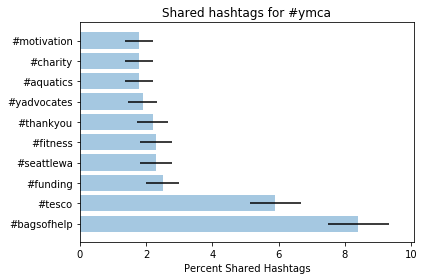

In [18]:
# This is the hashtag (system argument)
mytag = "ymca"
# Now get the raw data for co-tags of the hashtag "mytag"
myhisto = HashSearch('#'+mytag)
# Draw the histogram!
DrawHisto(myhisto,mytag)

In [21]:
# This is the hashtag (system argument)
mytag = "SJMCA"
# Now get the raw data for co-tags of the hashtag "mytag"
HashSearch('#'+mytag)


[]